# Классификация изображений

В этом практическом занятии мы будем решать задачу классификации картинок на 10 классов.

Мы будем работать с датасетом СIFAR10 и библиотекой PyTorch, которая создана специально для работы с нейронными сетями.

![alt text](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png)

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms
# метрика качества 
from sklearn.metrics import accuracy_score

In [ ]:
# конвертируем сразу в pytorch tensor
transform_train = transforms.Compose([
    transforms.ToTensor()
])

transform_val = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
# загрузим и сразу сконвертируем
train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_data = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_val)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# загрузчики треин и тест части
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle = True, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle = False)

In [ ]:
train_loader

In [ ]:
dataiter = iter(train_loader)
# батч картинок и батч ответов к картинкам

images, labels = dataiter.next()

In [ ]:
# размер датасета
images.shape, labels.shape

(torch.Size([16, 3, 32, 32]), torch.Size([16]))

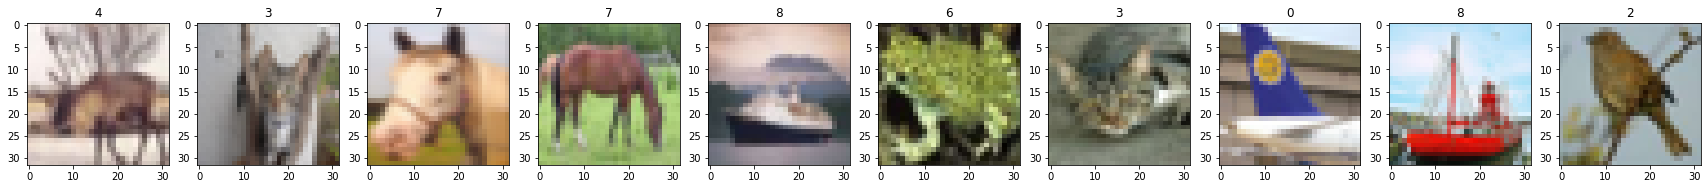

In [ ]:
# отобразим несколько картинок
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
        # загружаем изображения как тип ndarray (Height * Width * Channels)
        # будьте внимательны при преобразовании dtype в np.uint8 [целое число (от 0 до 255)].
        # в этом примере я не использую метод ToTensor() из torchvision.transforms
        # поэтому вы можете преобразовать форму numpy ndarray в тензор в PyTorch (H, W, C) --> (C, H, W)
        axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
        axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)

Таблица соответствий номеров ответов и классов:


| Label        | Class           |
| ------------- |:-------------:|
| 0     | Самолет |
| 1    | Автомобиль      | 
| 2 | Птица      |
| 3 | Кошка      |
| 4 | Олень      |
| 5 | Собака      |
| 6 | Лягушка     |
| 7 | Лошадь     |
| 8 | Корабль     |
| 9 | Грузовик     |


Создадим словарь соответствий номера и названия, чтобы проще интерпретировать выход нейронной сети:

In [ ]:
num_to_name = {
    0: "Самолет",
    1: "Автомобиль",
    2: "Птица",
    3: "Кошка",
    4: "Олень",
    5: "Собака",
    6: "Лягушка",
    7: "Лошадь",
    8: "Корабль",
    9: "Грузовик"
}


Импортируем нужные модули для обучения сети:

In [ ]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активайии для слоев нейронных сетей
import torch.nn.functional as F

# Обучение и тест базовой сети

Для начала построим двуслойную полносвязную нейронную сеть, обучим ее и посчитаем метрику accuracy на тестовой выборке:

<a href="https://ibb.co/prDn4RG"><img src="https://i.ibb.co/G3wFCtB/Screen-Shot-2020-03-14-at-9-43-10-PM.png" alt="Screen-Shot-2020-03-14-at-9-43-10-PM" border="0"></a>

In [ ]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        self.fc1 = nn.Linear(32*32*3, 256) # полносвязные слои - вход и выход
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        # forward pass сети

        # переводим входной объект из картинки в вектор
        x = self.flatten(x)
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.fc1(x))
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = F.softmax(self.fc2(x), dim=1)
        return x

Давайте вынесем код обучения сети в отдельную функцию, чтобы каждый раз при изменении сети не копировать его. Код обучения мы менять не будем.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def train(net, n_epoch=2):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # acc по test
    best_accuracy = 0
    # обучаем сеть 2 эпохи
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch
            
            # обнуляем градиент
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
            # bаckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()
            
            # проверяем качество каждые 1500 батчей (~пол эпохи)
            if i % 1500 ==0:
                # менеджер упарвления контекстом торча указывает на то, чтобы не обновлять параметры
                with torch.no_grad():
                    accuracy = []
                    for batch in test_loader:
                        x, y = batch
                        y_pred = net(x)
                        # loss = loss_fn(y_pred, y)
                        # находим accuracy батча с теста
                        accuracy.append(accuracy_score(y.detach().numpy(), np.argmax(y_pred.detach().numpy(), axis=1)))
                    # усредняем accuracy всех батчей на тесте
                    accuracy = np.mean(np.array(accuracy))
                    # если стало лучше - сохраняем на диск и обновляем лучшую метрику
                    if accuracy > best_accuracy:
                        print('New best model with test acc:', accuracy)
                        torch.save(net.state_dict(), './best_model.pt')
                        best_accuracy = accuracy

            # выведем текущий loss
            running_loss += loss.item()
            # выведем качество каждые 500 батчей
            if i % 500 == 499:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0

    print('Обучение закончено')
    return net

In [ ]:
# объявляем сеть
net = SimpleNet()
# теперь обучить сеть можно вызвав функцию train и передав туда переменную сети.
net = train(net)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.1
[1,   500] loss: 2.268
[1,  1000] loss: 2.198
[1,  1500] loss: 2.174
New best model with test acc: 0.2739
[1,  2000] loss: 2.164
[1,  2500] loss: 2.162
[1,  3000] loss: 2.165
New best model with test acc: 0.309


  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.3115
[2,   500] loss: 2.140
[2,  1000] loss: 2.144
[2,  1500] loss: 2.140
[2,  2000] loss: 2.130
[2,  2500] loss: 2.135
[2,  3000] loss: 2.119
New best model with test acc: 0.3252
Обучение закончено


In [ ]:
# загрузка лучшей модели после
# model = SimpleNet()
# model.load_state_dict(torch.load('./best_model.pt'))
# model.eval()

Посчитаем accuracy на test:

In [ ]:
with torch.no_grad():
    accuracy = []
    for batch in test_loader:
        x, y = batch
        y_pred = net(x)
        accuracy.append(accuracy_score(y.numpy(), np.argmax(y_pred.detach().numpy(), axis=1)))
    accuracy = np.mean(np.array(accuracy))

print('accuracy', accuracy)

accuracy 0.3465


# Обучение сверточной сети

Наша полносвязная двухслойная сеть не очень хорошо справляется с поставленной задачей. Давайте попробуем объявить и обучить сверточную нейронную сеть.

Наша нейронная сеть будет сожержать три слоя: два сверточных и один полносвязный. 
В качестве функции активации для внутренних слоев будем использовать [relu](https://neurohive.io/ru/osnovy-data-science/activation-functions/), для последнего слоя -- [softmax](https://neurohive.io/ru/osnovy-data-science/activation-functions/)

In [ ]:
# класс для удобного перевода картинки из двумерного объекта в вектор
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, kernel_size=3)
        self.conv2 = nn.Conv2d(20, 3, kernel_size=3) 
        self.flatten = Flatten()
        self.fc = nn.Linear(2352, 10) # какой тут будет размер входа? не всегда очевидно, особенно когда слоев много и этапов много, пробуйте выводить x.size() при прямом проходе
    
    def forward(self, x):
        # forward pass сети
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.flatten(x)
        # print(x.size())
        # умножение на матрицу весов 2 слоя и применение функции активации
        x = F.softmax(self.fc(x), dim=1)
        # print(x.shape)
        return x

In [ ]:
# объявляем сеть
net = ConvNet()

In [ ]:
# обучаем
net = train(net)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.1048
[1,   500] loss: 2.232
[1,  1000] loss: 2.203
[1,  1500] loss: 2.197
New best model with test acc: 0.2821


KeyboardInterrupt: ignored

In [ ]:
# проверяем по метрикам
with torch.no_grad():
    accuracy = []
    for batch in test_loader:
        x, y = batch
        y_pred = net(x)
        accuracy.append(accuracy_score(y.numpy(), np.argmax(y_pred.detach().numpy(), axis=1)))
    accuracy = np.mean(np.array(accuracy))

print('accuracy', accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


accuracy 0.3873


# CUDA

In [ ]:
device = torch.device('cuda')

In [ ]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.get_device_name()

'Tesla K80'

Все, что нам надо добавить - это .cuda() или .to(device), чтобы не только нейросеть была на видеокарте, но и обарбатываемые объекты были на видеопамяти

In [ ]:
def train(net, n_epoch=2):
    # выбираем функцию потерь
    loss_fn = torch.nn.CrossEntropyLoss()

    # выбираем алгоритм оптимизации и learning_rate
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # acc по test
    best_accuracy = 0
    # обучаем сеть 2 эпохи
    for epoch in tqdm(range(n_epoch)):

        running_loss = 0.0
        train_dataiter = iter(train_loader)
        for i, batch in enumerate(tqdm(train_dataiter)):
            # так получаем текущий батч
            X_batch, y_batch = batch
            # переносим его на видеопамять
            # если точно уверены, что это гпу - можно написать .cuda()
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # обнуляем веса
            optimizer.zero_grad()

            # forward pass (получение ответов на батч картинок)
            y_pred = net(X_batch)
            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(y_pred, y_batch)
            # bsckpropagation (вычисление градиентов)
            loss.backward()
            # обновление весов сети
            optimizer.step()

            # проверяем качество каждые 1500 батчей (~пол эпохи)
            if i % 1500 ==0:
                # менеджер упарвления контекстом торча указывает на то, чтобы не обновлять параметры
                with torch.no_grad():
                    accuracy = []
                    for batch in test_loader:
                        x, y = batch
                        # переносим на гпу
                        x = x.to(device)
                        y = y.to(device)
                        # прогнозируем
                        y_pred = net(x)
                        # loss = loss_fn(y_pred, y)
                        # находим accuracy батча с теста
                        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
                    # усредняем accuracy всех батчей на тесте
                    accuracy = np.mean(np.array(accuracy))
                    # если стало лучше - сохраняем на диск и обновляем лучшую метрику
                    if accuracy > best_accuracy:
                        print('New best model with test acc:', accuracy)
                        torch.save(net.state_dict(), './best_model.pt')
                        best_accuracy = accuracy

            # выведем текущий loss
            running_loss += loss.item()
            # выведем качество каждые 500 батчей
            if i % 500 == 499:
                print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0

    print('Обучение закончено')
    return net

In [ ]:
# инициализируем сеть на видеокарте
net = ConvNet().to(device)
# обучаем
net = train(net, n_epoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.1058
[1,   500] loss: 2.236
[1,  1000] loss: 2.184
[1,  1500] loss: 2.178
New best model with test acc: 0.3147
[1,  2000] loss: 2.171
[1,  2500] loss: 2.161
[1,  3000] loss: 2.167
New best model with test acc: 0.3171


  0%|          | 0/3125 [00:00<?, ?it/s]

[2,   500] loss: 2.155
[2,  1000] loss: 2.158
[2,  1500] loss: 2.151
[2,  2000] loss: 2.142
[2,  2500] loss: 2.152
[2,  3000] loss: 2.151
New best model with test acc: 0.3174


  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.3338
[3,   500] loss: 2.141
[3,  1000] loss: 2.135
[3,  1500] loss: 2.149
[3,  2000] loss: 2.140
[3,  2500] loss: 2.137
[3,  3000] loss: 2.134


  0%|          | 0/3125 [00:00<?, ?it/s]

[4,   500] loss: 2.140
[4,  1000] loss: 2.129
[4,  1500] loss: 2.128
New best model with test acc: 0.3397
[4,  2000] loss: 2.116
[4,  2500] loss: 2.128
[4,  3000] loss: 2.122
New best model with test acc: 0.3464


  0%|          | 0/3125 [00:00<?, ?it/s]

[5,   500] loss: 2.117
[5,  1000] loss: 2.120
[5,  1500] loss: 2.115
[5,  2000] loss: 2.127
[5,  2500] loss: 2.127
[5,  3000] loss: 2.124


  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.3482
[6,   500] loss: 2.118
[6,  1000] loss: 2.107
[6,  1500] loss: 2.112
[6,  2000] loss: 2.108
[6,  2500] loss: 2.111
[6,  3000] loss: 2.126


  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.3514
[7,   500] loss: 2.110
[7,  1000] loss: 2.107
[7,  1500] loss: 2.109
[7,  2000] loss: 2.116
[7,  2500] loss: 2.105
[7,  3000] loss: 2.109
New best model with test acc: 0.3559


  0%|          | 0/3125 [00:00<?, ?it/s]

[8,   500] loss: 2.103
[8,  1000] loss: 2.110
[8,  1500] loss: 2.108
[8,  2000] loss: 2.109
[8,  2500] loss: 2.106
[8,  3000] loss: 2.104


  0%|          | 0/3125 [00:00<?, ?it/s]

[9,   500] loss: 2.105
[9,  1000] loss: 2.106
[9,  1500] loss: 2.116
[9,  2000] loss: 2.098
[9,  2500] loss: 2.098
[9,  3000] loss: 2.104
New best model with test acc: 0.3578


  0%|          | 0/3125 [00:00<?, ?it/s]

[10,   500] loss: 2.092
[10,  1000] loss: 2.105
[10,  1500] loss: 2.091
New best model with test acc: 0.3612
[10,  2000] loss: 2.087
[10,  2500] loss: 2.073
[10,  3000] loss: 2.080
New best model with test acc: 0.3836
Обучение закончено


In [ ]:
with torch.no_grad():
    accuracy = []
    for batch in test_loader:
        x, y = batch
        # переносим на гпу
        x = x.to(device)
        y = y.to(device)
        # прогнозируем
        y_pred = net(x)
        # loss = loss_fn(y_pred, y)
        # находим accuracy батча с теста
        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
    # усредняем accuracy всех батчей на тесте
    accuracy = np.mean(np.array(accuracy))

print('Test accuracy', accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test accuracy 0.4619


# Немного современных нововведений

In [ ]:
class Conv3Pool1_Sum(nn.Module):
    """ Блок свёртки и пулинга со skip-connection и сложением на конце"""
    def __init__(self, in_c, out_c, kernel=3, pad=1, norm=False):
        super().__init__()
        self.conv1 = nn.Sequential(
                      nn.Conv2d( in_channels=in_c,
                                out_channels=out_c,
                                kernel_size=kernel,
                                padding=pad),    # вход 256, 256
                      nn.LeakyReLU(), 
                      )               
        self.bn1 = None
        if norm:
            self.bn1 = nn.BatchNorm2d(out_c) 
        self.conv2 = nn.Sequential(                          
                      nn.Conv2d( in_channels=out_c, out_channels=out_c, kernel_size=kernel, padding=pad),    
                      nn.LeakyReLU(), 
                      # nn.BatchNorm2d(out_c)
                      )         
        self.conv3 = nn.Sequential(                          
                      nn.Conv2d( in_channels=out_c, out_channels=out_c, kernel_size=kernel, padding=pad),    
                      nn.LeakyReLU(), 
                      # nn.BatchNorm2d(out_c)
                      )         
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.init_weights()


    def init_weights(self):
        for l in [self.conv1, self.conv2, self.conv3]:
            # He инициализация весов из нормального распределения
            # по-умолчанию используется Xavier инициализация
            torch.nn.init.kaiming_normal_(l[0].weight, a=0.01, mode='fan_in', nonlinearity='leaky_relu')  # a -- коэффициент определяющий наклон левой части ReLU

    def forward(self, x):
        x1 = self.conv1(x)
        if self.bn1:
            x1 = self.bn1(x1)
        x  = self.conv2(x1)
        x2 = self.conv3(x)
        x = x1 + x2
        x = self.pool1(x)
        return x

In [ ]:
class CNN(nn.Module):
    """Сеть с skip-connection и конкатенацией внутри отдельных блоков"""
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = Conv3Pool1_Sum(3,   32)                                             # 128
        self.conv2 = Conv3Pool1_Sum(32,  64)                                             # 64
        self.conv3 = Conv3Pool1_Sum(64,  128)                                             # 32
        self.conv4 = Conv3Pool1_Sum(128, 128, norm=True)                                  # 16

        self.fc1 = nn.Sequential(            
                      nn.Linear(in_features=512, out_features=256, ),
                      nn.Dropout(0.2),
                      nn.LeakyReLU())
        # self.fc2 = nn.Sequential(            
        #               nn.Linear(in_features=512, out_features=64),
        #               nn.LeakyReLU())
        self.fc2_bn =  nn.BatchNorm1d(256)
        self.out = nn.Sequential(            
                      nn.Linear(in_features=256, out_features=n_classes),
                      # nn.SoftMax()
                                          )
        self.init_weights()
                          
    
    def init_weights(self):
        for l in [self.fc1, self.out]:
            # He инициализация весов из нормального распределения
            # по-умолчанию используется Xavier инициализация
            torch.nn.init.kaiming_normal_(l[0].weight, a=0.01, mode='fan_in', nonlinearity='leaky_relu')  # a -- коэффициент определяющий наклон левой части ReLU

    def forward(self, x):
        # x = x.view(x.shape[0], 1, 256, 256 )
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # print(x.size())
        x = torch.flatten(x, 1)
        # print(x.size())
        x = self.fc1(x)
        # x = self.fc2(x)
        # if self.training: 
        x = self.fc2_bn(x)   # иначе бачнорм на одном объекте упадёт на инференсе
        x = self.out(x)
        return x

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

# тут 10 - кол-во классов
cnn = CNN(10).to(device)

In [ ]:
params_n = sum(p.numel() for p in cnn.parameters() if p.requires_grad)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(cnn.parameters(), lr=1e-5)

In [ ]:
# обучаем
net = train(cnn, n_epoch=3)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.1014
[1,   500] loss: 2.289
[1,  1000] loss: 1.982
[1,  1500] loss: 1.803
New best model with test acc: 0.3311
[1,  2000] loss: 1.706
[1,  2500] loss: 1.627
[1,  3000] loss: 1.510
New best model with test acc: 0.5026


  0%|          | 0/3125 [00:00<?, ?it/s]

[2,   500] loss: 1.403
[2,  1000] loss: 1.290
[2,  1500] loss: 1.243
New best model with test acc: 0.5599
[2,  2000] loss: 1.173
[2,  2500] loss: 1.137
[2,  3000] loss: 1.074
New best model with test acc: 0.6303


  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.6561
[3,   500] loss: 0.996
[3,  1000] loss: 0.943
[3,  1500] loss: 0.940
New best model with test acc: 0.6724
[3,  2000] loss: 0.924
[3,  2500] loss: 0.896
[3,  3000] loss: 0.868
New best model with test acc: 0.7049
Обучение закончено


In [ ]:
with torch.no_grad():
    accuracy = []
    for batch in test_loader:
        x, y = batch
        # переносим на гпу
        x = x.to(device)
        y = y.to(device)
        # прогнозируем
        y_pred = net(x)
        # loss = loss_fn(y_pred, y)
        # находим accuracy батча с теста
        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
    # усредняем accuracy всех батчей на тесте
    accuracy = np.mean(np.array(accuracy))

print('Test accuracy', accuracy)

Test accuracy 0.7153


Загрузка сохраненной модели (подробнее [тут](https://pytorch.org/tutorials/beginner/saving_loading_models.html))

In [ ]:
# для загрузки сохранения можно испольовать такой варинат сохранения - лучше рабоатет между cpu/gpu
# почистим кеш
torch.cuda.empty_cache()
import gc
gc.collect()

# загрузим модель (на деле лучше сохранять ту, которую на валидации выдавала результаты лучше, для этого следует испльзовать with torch.no_grad(): ... код для валидационного прогона)
cnn_loaded = CNN(10).to(device)
cnn_loaded.load_state_dict(torch.load('best_model.pt'))
cnn_loaded.eval()

CNN(
  (conv1): Conv3Pool1_Sum(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (conv3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Conv3Pool1_Sum(
    (conv1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
    )
    (conv3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [ ]:
with torch.no_grad():
    accuracy = []
    for batch in test_loader:
        x, y = batch
        # переносим на гпу
        x = x.to(device)
        y = y.to(device)
        # прогнозируем
        y_pred = cnn_loaded(x)
        # loss = loss_fn(y_pred, y)
        # находим accuracy батча с теста
        accuracy.append(accuracy_score(y.detach().cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=1)))
    # усредняем accuracy всех батчей на тесте
    accuracy = np.mean(np.array(accuracy))

print('Test accuracy', accuracy)

Test accuracy 0.71


## Чуть больше эпох

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

# тут 10 - кол-во классов
cnn = CNN(10).to(device)

In [ ]:
# обучаем
net = train(cnn, n_epoch=20)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.1141
[1,   500] loss: 2.326
[1,  1000] loss: 2.012
[1,  1500] loss: 1.817
New best model with test acc: 0.3549
[1,  2000] loss: 1.671
[1,  2500] loss: 1.556
[1,  3000] loss: 1.485
New best model with test acc: 0.4673


  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.4883
[2,   500] loss: 1.325
[2,  1000] loss: 1.274
[2,  1500] loss: 1.192
New best model with test acc: 0.5816
[2,  2000] loss: 1.152
[2,  2500] loss: 1.090
[2,  3000] loss: 1.082
New best model with test acc: 0.636


  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.643
[3,   500] loss: 0.988
[3,  1000] loss: 0.938
[3,  1500] loss: 0.921
New best model with test acc: 0.6788
[3,  2000] loss: 0.911
[3,  2500] loss: 0.888
[3,  3000] loss: 0.843
New best model with test acc: 0.6982


  0%|          | 0/3125 [00:00<?, ?it/s]

[4,   500] loss: 0.788
[4,  1000] loss: 0.769
[4,  1500] loss: 0.769
New best model with test acc: 0.7346
[4,  2000] loss: 0.742
[4,  2500] loss: 0.716
[4,  3000] loss: 0.727
New best model with test acc: 0.7485


  0%|          | 0/3125 [00:00<?, ?it/s]

[5,   500] loss: 0.645
[5,  1000] loss: 0.648
[5,  1500] loss: 0.647
[5,  2000] loss: 0.622
[5,  2500] loss: 0.637
[5,  3000] loss: 0.628
New best model with test acc: 0.764


  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.7673
[6,   500] loss: 0.507
[6,  1000] loss: 0.562
[6,  1500] loss: 0.548
New best model with test acc: 0.7696
[6,  2000] loss: 0.550
[6,  2500] loss: 0.570
[6,  3000] loss: 0.554
New best model with test acc: 0.7825


  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.7864
[7,   500] loss: 0.449
[7,  1000] loss: 0.448
[7,  1500] loss: 0.465
[7,  2000] loss: 0.491
[7,  2500] loss: 0.490
[7,  3000] loss: 0.474
New best model with test acc: 0.7919


  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.794
[8,   500] loss: 0.357
[8,  1000] loss: 0.410
[8,  1500] loss: 0.415
[8,  2000] loss: 0.417
[8,  2500] loss: 0.416
[8,  3000] loss: 0.438


  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.8015
[9,   500] loss: 0.315
[9,  1000] loss: 0.321
[9,  1500] loss: 0.354
[9,  2000] loss: 0.344
[9,  2500] loss: 0.363
[9,  3000] loss: 0.342


  0%|          | 0/3125 [00:00<?, ?it/s]

[10,   500] loss: 0.264
[10,  1000] loss: 0.285
[10,  1500] loss: 0.303
[10,  2000] loss: 0.306
[10,  2500] loss: 0.311
[10,  3000] loss: 0.311


  0%|          | 0/3125 [00:00<?, ?it/s]

[11,   500] loss: 0.212
[11,  1000] loss: 0.244
[11,  1500] loss: 0.269
[11,  2000] loss: 0.250
[11,  2500] loss: 0.271
[11,  3000] loss: 0.262


  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.8021
[12,   500] loss: 0.180
[12,  1000] loss: 0.208
[12,  1500] loss: 0.226
New best model with test acc: 0.803
[12,  2000] loss: 0.230
[12,  2500] loss: 0.238
[12,  3000] loss: 0.239
New best model with test acc: 0.8067


  0%|          | 0/3125 [00:00<?, ?it/s]

[13,   500] loss: 0.160
[13,  1000] loss: 0.195
[13,  1500] loss: 0.209
[13,  2000] loss: 0.196
[13,  2500] loss: 0.213
[13,  3000] loss: 0.201


  0%|          | 0/3125 [00:00<?, ?it/s]

[14,   500] loss: 0.144
[14,  1000] loss: 0.155
[14,  1500] loss: 0.193
[14,  2000] loss: 0.184
[14,  2500] loss: 0.177
[14,  3000] loss: 0.206


  0%|          | 0/3125 [00:00<?, ?it/s]

New best model with test acc: 0.8084
[15,   500] loss: 0.115
[15,  1000] loss: 0.136
[15,  1500] loss: 0.156
[15,  2000] loss: 0.174


KeyboardInterrupt: ignored

In [ ]:
# accuracy для каждого батча на тесте
acc_batches = []

for batch in tqdm_notebook(test_loader):
    X, y = batch
    # предсказания сразу в numpy сохраним
    np_preds = np.argmax(net(X.cuda()).detach().cpu().numpy(), axis=1) # находим макс значение из вероятностного распределения
    # ответы тоже в numpy
    labels = y.cpu().numpy()
    acc = accuracy_score(labels, np_preds)

    acc_batches.append(acc)

np.array(acc_batches).mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


0.8025

# Произвольные данные + Дообучение нейросети

Будем решать задачу классификации картинок и работать с библиотекой PyTorch.
Мы будем использовать предобученную на ImageNet сеть Vgg19 для дообучения на датасете для классификации кошек и собак.

![alt text](https://i.ytimg.com/vi/IiilA0dsciY/maxresdefault.jpg)

## Загрузка датасета

Для загрузки датасета из интернета воспользуемся командами bash. Bash -- язык командной строки linux. В ячейках jupyter notebook можно запускать команды bash, предварительно написав ! в начале ячейки.

In [ ]:
# команда wget скачивает файлы из интернета по ссылке
! wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
# команда unzip разархивирует zip-архив
! unzip cats_and_dogs_filtered.zip

--2022-01-28 16:55:06--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  97.6MB/s    in 0.7s    

2022-01-28 16:55:08 (97.6 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.

In [ ]:
# команда ls выводит список файлов в текущей директории
! ls

best_model.pt		cats_and_dogs_filtered.zip  sample_data
cats_and_dogs_filtered	data


In [ ]:
# команда ls ИМЯ_ПАПКИ выводит список файлов в указанной папке
! ls cats_and_dogs_filtered/

train  validation  vectorize.py


In [ ]:
! ls cats_and_dogs_filtered/train

cats  dogs


In [ ]:
# модули библиотеки PyTorch
import torch
from torchvision import datasets, transforms
# метрика качества 
from sklearn.metrics import accuracy_score

In [ ]:
# можно из коробки приводить все изображения к единому формату, конвертировать в торч тензор и нормализовывать
transform_train = transforms.Compose([
         transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], # это среднее и стандартное отклонение всего датасета (обычно imagenet), на котором обучали большую сеть
                              std=[0.229, 0.224, 0.225]),
])
# отдельный для теста
transform_val = transforms.Compose([
         transforms.Resize((224, 224)),                           
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

In [ ]:
# при загрузке сразу указываем как предобрабатывать
train_data = datasets.ImageFolder("cats_and_dogs_filtered/train/", transform=transform_train, )
test_data = datasets.ImageFolder("cats_and_dogs_filtered/validation", transform=transform_val)
# там же в transforms с версии торча 1.8+ появилась и аугментация

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: cats_and_dogs_filtered/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
# разбиваем сразу на батчи (обычно берут под максимум, который влезает в память)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle = True, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle = False, pin_memory=True, num_workers=2)

In [ ]:
dataiter = iter(train_loader)
# батч картинок и батч ответов к картинкам
images, labels = dataiter.next()

In [ ]:
# размер картинок
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

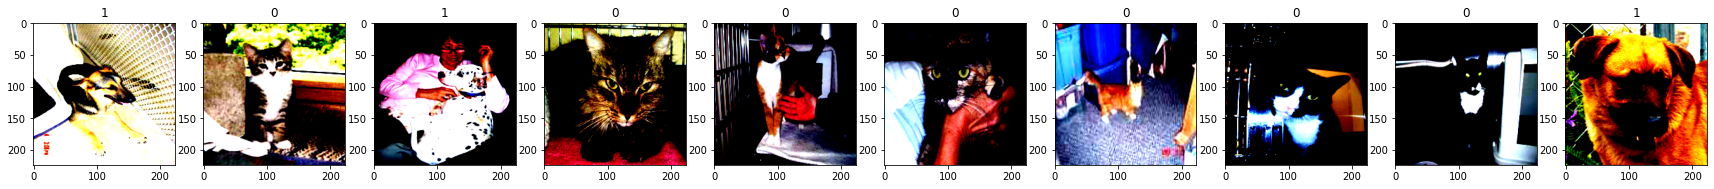

In [ ]:
# посмотрим на пару из них
def show_imgs(imgs, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    for i, axis in enumerate(axes):
      axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
      axes[i].set_title(labels[i].numpy())
    plt.show()

show_imgs(images, labels)

# Файн тюнинг сети

In [ ]:
# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активайии для слоев нейронных сетей
import torch.nn.functional as F

Наша сверточная сеть не очень хорошо справляется с поставленной задачей, она переобучается Давайте попробуем дообучить сеть VGG16, обученную на ImageNet, под нашу задачу.

Список сетей, предобученных на ImageNet, которые есть в библиотеке PyTorch: https://pytorch.org/vision/stable/models.html

In [ ]:
from torchvision import models
vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
vgg16.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [ ]:
# нам не нужен последний слой, обрезаем его
vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children()))[:-1]

In [ ]:
vgg16.parameters

<bound method Module.parameters of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

In [ ]:
class New_VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg16 = vgg16 # вся огромная нейросеть в одну строчку
        for param in self.vgg16.features.parameters(): # отключаем для нее обновление параметров
            param.requires_grad = False
        self.fc = nn.Linear(4096, 2) # добавляем новый слой
    
    def forward(self, x):
        # forward pass сети
        # умножение на матрицу весов 1 слоя и применение функции активации
        x = self.vgg16(x)
        x = self.fc(x)
        return x

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [ ]:
net = New_VGG16().to(device)
train(net)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

New best model with test acc: 0.67578125


  0%|          | 0/63 [00:00<?, ?it/s]

New best model with test acc: 0.943359375
Обучение закончено


New_VGG16(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16)

In [ ]:
test_dataiter = iter(test_loader)
images, labels = test_dataiter.next()

In [ ]:
labels_net = []
labels_true = []
for images, labels in test_loader:
    labels_true.extend(labels)
    labels_net.extend(net.forward(images.cuda()).detach().cpu().numpy())

In [ ]:
labels_net

[array([ 57.27911, -69.78779], dtype=float32),
 array([ 35.14555 , -30.064697], dtype=float32),
 array([ 17.996754, -22.99289 ], dtype=float32),
 array([ 32.53866 , -36.222424], dtype=float32),
 array([-6.625702,  5.782338], dtype=float32),
 array([ 16.723179, -21.193901], dtype=float32),
 array([-6.323339 ,  4.1616683], dtype=float32),
 array([ 66.431915, -50.855816], dtype=float32),
 array([ 13.814399, -16.730698], dtype=float32),
 array([-26.98403 ,  30.906996], dtype=float32),
 array([-2.7049985, -4.6801767], dtype=float32),
 array([ 53.02239 , -54.533264], dtype=float32),
 array([ 44.02437 , -43.556976], dtype=float32),
 array([ 28.635334, -40.672016], dtype=float32),
 array([ 43.79892 , -62.386086], dtype=float32),
 array([ 28.033302, -35.408615], dtype=float32),
 array([ 33.43976 , -47.347343], dtype=float32),
 array([ 25.11234, -20.38913], dtype=float32),
 array([ 24.451698, -25.108948], dtype=float32),
 array([ 13.694817, -20.316463], dtype=float32),
 array([ 51.410633, -37.64

In [ ]:
accuracy_score(labels_true, np.argmax(np.array(labels_net), axis=1))

0.968

In [ ]:
accuracy_score(labels.numpy(), np.argmax(net.forward(images.cuda()).detach().cpu().numpy(), axis=1))

1.0

# Кастомные даталоадеры

Код ниже скачивает данные НеМнист - набор букв

In [ ]:
import os
from glob import glob

import numpy as np
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split


def load_notmnist(
    path='./notMNIST_small',
    letters='ABCDEFGHIJ',
    img_shape=(28,28),
    test_size=0.25,
    one_hot=False,
):
    # download data if it's missing. If you have any problems, go to the urls and load it manually.
    if not os.path.exists(path):
        if not os.path.exists('./notMNIST_small.tar.gz'):
            print("Downloading data...")
            assert os.system('curl http://yaroslavvb.com/upload/notMNIST/notMNIST_small.tar.gz > notMNIST_small.tar.gz') == 0
        print("Extracting ...")
        assert os.system('tar -zxvf notMNIST_small.tar.gz > untar_notmnist.log') == 0

    data,labels = [],[]
    print("Parsing...")
    for img_path in glob(os.path.join(path,'*/*')):
        class_i = img_path.split(os.sep)[-2]
        if class_i not in letters: continue
        try:
            data.append(imread(img_path))
            labels.append(class_i,)
        except:
            print("found broken img: %s [it's ok if <10 images are broken]" % img_path)

    data = np.stack(data)[:,None].astype('float32')
    data = (data - np.mean(data)) / np.std(data)

    #convert classes to ints
    letter_to_i = {l:i for i,l in enumerate(letters)}
    labels = np.array(list(map(letter_to_i.get, labels)))

    if one_hot:
        labels = (np.arange(np.max(labels) + 1)[None,:] == labels[:, None]).astype('float32')

    #split into train/test
    if test_size == 0:
        X_train, X_test, y_train, y_test = data, [], labels, []
    else:
        X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size, random_state=42)

    print("Done")
    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = load_notmnist()
type(X_train)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


numpy.ndarray

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision
from torchvision import transforms

Хороший пример:

https://albumentations.ai/docs/examples/pytorch_classification/

In [ ]:
# imageFolder не сможет нормально обработать выборки, которые не помещаются в оперативку
class DatasetMNIST(Dataset):
    def __init__(self, path='./notMNIST_small', letters='ABCDEFGHIJ', transform=None):
        # мы можем использовать imageFolder для загрузки какой-то части датасета
        self.data, self.labels, _ ,_  = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index].transpose(1, 2, 0) # формат каналов торча
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
full_dataset = DatasetMNIST('./notMNIST_small', 'AB', transform=None)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [ ]:
# встроенный метод получает нужнуй элемент по индексу
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [ ]:
a = torchvision.transforms.ToTensor()

a(img).shape

torch.Size([1, 28, 28])

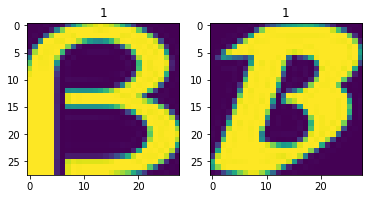

In [ ]:
# отобразим пару букв
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28,28]))
    plt.title(str(full_dataset[inds[i]][1]))

In [ ]:
# создаем привычный загрузчик
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=2)

In [ ]:

# мы можем использовать dataloader в качестве итератора с помощью функции iter()
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>


In [ ]:
# мы можем просматривать изображения и метки пакетного размера, извлекая данные методом .next()
images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 28, 28, 1])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


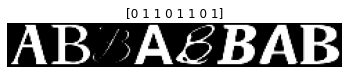

In [ ]:
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images.permute([0, 3, 1, 2]))

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

с версии 1.9 можно НА ХОДУ применять целый спектр встроенный преобразований
https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

In [ ]:
# конвертируем в тензор
train_dataset_with_transform = DatasetMNIST(
    transform=torchvision.transforms.ToTensor()
)

# например обрезать по центру
# transforms.Compose([
#     transforms.CenterCrop(10),
#     # https://github.com/albumentations-team/albumentations
#     transforms.ToTensor(),
# ])

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [ ]:
img, lab = train_dataset_with_transform.__getitem__(0)

print('image shape at the first row : {}'.format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [ ]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = train_iter_tr.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


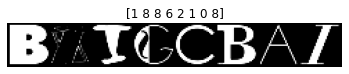

In [ ]:
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());

In [ ]:
class Flatten():
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [ ]:
a = Flatten()

In [ ]:
a(img).shape

torch.Size([784])

In [ ]:
new_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    Flatten()
])

In [ ]:
# взять случайные 20 процентов индексов из датасета
def subset_ind(dataset, ratio: float):
    return np.random.choice(len(dataset), size=int(ratio*len(dataset)), replace=False)

In [ ]:
dataset = DatasetMNIST(
    './notMNIST_small',
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f'\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}')

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


 dataset size: 3744, labels: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f'  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}')

  training size: 2996
validation size: 748


In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)

In [ ]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>
images shape on batch size = torch.Size([32, 28, 28, 1])
labels shape on batch size = torch.Size([32])


In [ ]:
device=torch.device('cuda')

model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Sigmoid(),
)
model = model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
import time

def train_model(model, train_loader, test_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                ep_val_loss.append(loss.item())
                y_pred = model(X_batch)
                y_pred = y_pred.max(1)[1].data
                ep_val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [ ]:
n_epochs = 30

loss_func = torch.nn.CrossEntropyLoss()
train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

RuntimeError: ignored

In [ ]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')
    axes[0].legend()

    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_accuracy)

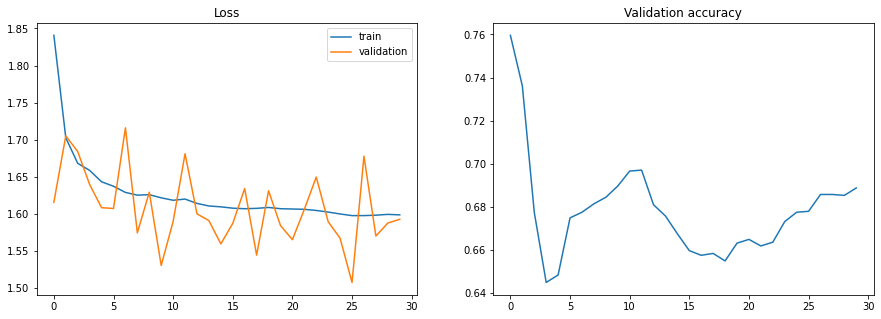

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [ ]:
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 0.971s
	  training loss: 1.841533
	validation loss: 1.820519
	validation accuracy: 0.366
Epoch 2 of 30 took 0.988s
	  training loss: 1.807027
	validation loss: 1.747916
	validation accuracy: 0.423
Epoch 3 of 30 took 0.967s
	  training loss: 1.802705
	validation loss: 1.829631
	validation accuracy: 0.392
Epoch 4 of 30 took 0.940s
	  training loss: 1.886861
	validation loss: 1.916251
	validation accuracy: 0.360
Epoch 5 of 30 took 1.007s
	  training loss: 1.945040
	validation loss: 2.028861
	validation accuracy: 0.278
Epoch 6 of 30 took 0.966s
	  training loss: 2.069035
	validation loss: 2.133405
	validation accuracy: 0.242
Epoch 7 of 30 took 0.977s
	  training loss: 2.142154
	validation loss: 2.146389
	validation accuracy: 0.226
Epoch 8 of 30 took 0.973s
	  training loss: 2.184264
	validation loss: 2.075179
	validation accuracy: 0.221
Epoch 9 of 30 took 0.923s
	  training loss: 2.191236
	validation loss: 2.013520
	validation accuracy: 0.213
Epoch 10 of 30 took 0.944s
	

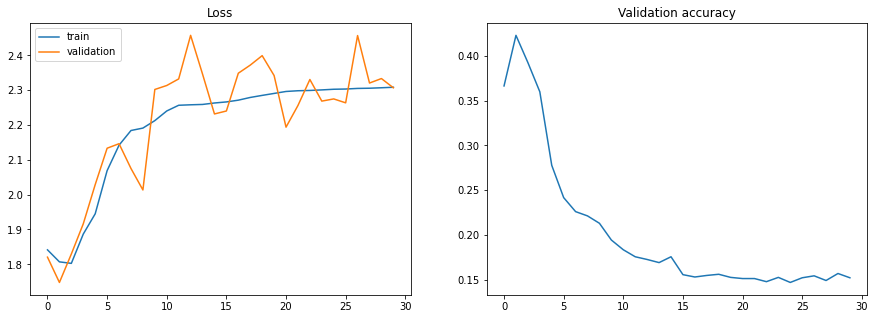

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [ ]:
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.Dropout(p=0.6),
    nn.BatchNorm1d(200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Dropout(p=0.6),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

Epoch 1 of 30 took 1.078s
	  training loss: 2.187512
	validation loss: 2.170685
	validation accuracy: 0.753
Epoch 2 of 30 took 1.048s
	  training loss: 2.095154
	validation loss: 2.099647
	validation accuracy: 0.818
Epoch 3 of 30 took 1.105s
	  training loss: 2.064059
	validation loss: 2.077372
	validation accuracy: 0.831
Epoch 4 of 30 took 1.029s
	  training loss: 2.054818
	validation loss: 2.092317
	validation accuracy: 0.827
Epoch 5 of 30 took 1.038s
	  training loss: 2.039232
	validation loss: 2.002623
	validation accuracy: 0.836
Epoch 6 of 30 took 0.990s
	  training loss: 2.045605
	validation loss: 2.007656
	validation accuracy: 0.852
Epoch 7 of 30 took 1.042s
	  training loss: 2.031397
	validation loss: 2.083600
	validation accuracy: 0.849
Epoch 8 of 30 took 1.026s
	  training loss: 2.027967
	validation loss: 2.069804
	validation accuracy: 0.852
Epoch 9 of 30 took 1.011s
	  training loss: 2.023078
	validation loss: 2.040241
	validation accuracy: 0.852
Epoch 10 of 30 took 1.011s
	

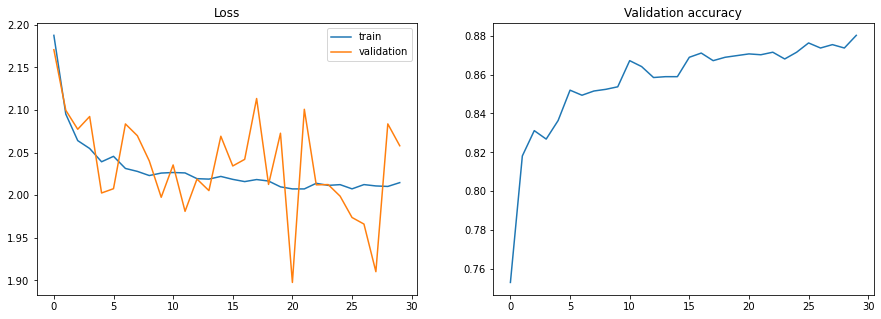

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

# Model checkpointing

Сохранение для продолжение обучения предполагает сохранение состояний оптимизатора

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {
        'state_dict': model.state_dict(),
        'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')